In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the dataset
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [2]:
# change column names to snake_case
train_df.columns = (
    train_df.columns.str.lower()
                    .str.strip()
                    .str.replace(' ', '_')
                    .str.replace(r'[^a-z0-9_]', '', regex=True)
)

test_df.columns = (
    test_df.columns.str.lower()
                    .str.strip()
                    .str.replace(' ', '_')
                    .str.replace(r'[^a-z0-9_]', '', regex=True)
)

# display the first few rows of the training dataset
#print(train_df.head(20))
#print(train_df.shape)
#print(train_df.info())
#print(train_df.isnull().sum())
#print(test_df.info())

In [3]:
# preprocessing the train_df dataset

# fill missing values in 'embarked' with the  mode and convert to numerical
train_df['embarked'].fillna(train_df['embarked'].mode()[0], inplace=True)
train_df['embarked'] = train_df['embarked'].str.strip().str.upper()
train_df['embarked'] = train_df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# fill missing values in 'age' with the median and create age bands
train_df['age'].fillna(train_df['age'].median(), inplace=True)
train_df['age_band'] = pd.cut(train_df['age'], 5)
print(train_df[['age_band', 'survived']].groupby('age_band').mean())
train_df.loc[train_df['age'] <= 16, 'age'] = 0
train_df.loc[(train_df['age'] > 16) & (train_df['age'] <= 32), 'age'] = 1
train_df.loc[(train_df['age'] > 32) & (train_df['age'] <= 48), 'age'] = 2
train_df.loc[(train_df['age'] > 48) & (train_df['age'] <= 64), 'age'] = 3
train_df.loc[train_df['age'] > 64, 'age'] = 4
#ageband
#(0.34, 16.336]    0.550000
#(16.336, 32.252]  0.344168
#(32.252, 48.168]  0.404255
#(48.168, 64.084]  0.434783
#(64.084, 80.0]    0.090909

# convert categorical columns like 'sex' and 'embarked' to numerical
train_df['sex'] = train_df['sex'].str.strip().str.lower()
train_df['sex'] = train_df['sex'].map({'male': 0, 'female': 1})

# creating fare bands 
train_df['fare_band'] = pd.qcut(train_df['fare'], 4)
print(train_df['fare_band'].value_counts(sort=False))
print(train_df[['fare_band', 'survived']].groupby('fare_band').mean())
train_df.loc[train_df['fare'] <= 7.91, 'fare'] = 0
train_df.loc[(train_df['fare'] > 7.91) & (train_df['fare'] <= 14.45), 'fare'] = 1
train_df.loc[(train_df['fare'] > 14.45) & (train_df['fare'] <= 31.0), 'fare'] = 2
train_df.loc[train_df['fare'] > 31.0, 'fare'] = 3
# (-0.001, 7.91]     223
#(7.91, 14.454]     224
#(14.454, 31.0]     222
#(31.0, 512.329]    222

# extracting titles from names
train_df['title'] = train_df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", 
    "Lady": "Rare", "Countess": "Rare", "Capt": "Rare",
    "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare",
    "Rev": "Rare", "Sir": "Rare", "Jonkheer": "Rare", "Dona": "Rare"  }
train_df['title'] = train_df['title'].replace(title_map)
title_mapping = {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Rare': 4}
train_df['title'] = train_df['title'].map(title_mapping).astype(int)
print(train_df['title'].value_counts())


# extracting passengers with family vs alone
train_df['family_size'] = train_df['sibsp'] + train_df['parch'] + 1
train_df['is_alone'] = 0
train_df.loc[train_df['family_size'] == 1, 'is_alone'] = 1
print(train_df[['family_size', 'survived']].groupby('family_size').mean())

# extracting initial letter of 'cabin' to check correlation with survival:            
train_df['cabin_letter'] = train_df['cabin'].str[0]
train_df['cabin_letter'] = train_df['cabin_letter'].fillna('U')      # Unknown
map = {char: idx for idx, char in enumerate(['U', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])}
train_df['cabin_letter'] = train_df['cabin_letter'].map(map)
correlation = train_df['cabin_letter'].corr(train_df['survived'])
print("Correlation between cabin letter and survival:", correlation)

# group size 
train_df['ticket_group_size'] = train_df.groupby('ticket')['ticket'].transform('count')

#trying some permutations of the dataset
train_df['pclass_sex'] = train_df['pclass'] * train_df['sex']
train_df['isalone_age'] = train_df['is_alone'] * train_df['age']
train_df['title_fare'] = train_df['title'] * train_df['fare']
train_df['fare_perperson'] = train_df['fare'] / train_df['ticket_group_size']

train_df.groupby('pclass_sex')['survived'].mean()
train_df['isalone_age_bin'] = pd.cut(train_df['is_alone'] * train_df['age'], 5)
print(train_df.groupby('isalone_age_bin')['survived'].mean()) # after binning age
#(-0.004, 0.8]    0.505405              mostly young or non-alone people
#(0.8, 1.6]       0.291209              mostly young people who were alone
#(1.6, 2.4]       0.336449              mostly middle-aged people who were alone
#(2.4, 3.2]       0.292683              mostly older people who were not alone
#(3.2, 4.0]       0.111111              mostly older people who were alone

#train_df['isalone_age_qbin'] = pd.qcut(train_df['isalone_age'], q=5, duplicates='drop')
#print(train_df['isalone_age_qbin'].value_counts(sort=False))
#(-0.001, 1.0]    734
#(1.0, 4.0]       157

# dropping unnecessary columns
train_df.drop(['passengerid', 'name', 'ticket', 'age_band', 'fare_band', 'cabin', 'isalone_age_bin'], axis=1, inplace=True)

# saving the cleaned training dataset
train_df.to_csv("data/train_cleaned.csv", index=False)

                  survived
age_band                  
(0.34, 16.336]    0.550000
(16.336, 32.252]  0.344168
(32.252, 48.168]  0.404255
(48.168, 64.084]  0.434783
(64.084, 80.0]    0.090909
fare_band
(-0.001, 7.91]     223
(7.91, 14.454]     224
(14.454, 31.0]     222
(31.0, 512.329]    222
Name: count, dtype: int64
                 survived
fare_band                
(-0.001, 7.91]   0.197309
(7.91, 14.454]   0.303571
(14.454, 31.0]   0.454955
(31.0, 512.329]  0.581081
title
2    517
1    185
3    126
0     40
4     23
Name: count, dtype: int64
             survived
family_size          
1            0.303538
2            0.552795
3            0.578431
4            0.724138
5            0.200000
6            0.136364
7            0.333333
8            0.000000
11           0.000000
Correlation between cabin letter and survival: 0.287944155771809
isalone_age_bin
(-0.004, 0.8]    0.505405
(0.8, 1.6]       0.291209
(1.6, 2.4]       0.336449
(2.4, 3.2]       0.292683
(3.2, 4.0]       0.1111

<>:42: SyntaxWarning: invalid escape sequence '\.'
<>:42: SyntaxWarning: invalid escape sequence '\.'
/var/folders/_4/4g43_y4d7jsdwk3z2vlh3vpw0000gn/T/ipykernel_67882/689538725.py:42: SyntaxWarning: invalid escape sequence '\.'
  train_df['title'] = train_df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/var/folders/_4/4g43_y4d7jsdwk3z2vlh3vpw0000gn/T/ipykernel_67882/689538725.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['embarked'].fillna(train_df['embarked'].mode()[0], inplace=True)
/var/folders/_4/4g43

In [4]:
print(train_df.dtypes)
print(train_df.isnull().sum())

survived               int64
pclass                 int64
sex                    int64
age                  float64
sibsp                  int64
parch                  int64
fare                 float64
embarked               int64
title                  int64
family_size            int64
is_alone               int64
cabin_letter           int64
ticket_group_size      int64
pclass_sex             int64
isalone_age          float64
title_fare           float64
fare_perperson       float64
dtype: object
survived             0
pclass               0
sex                  0
age                  0
sibsp                0
parch                0
fare                 0
embarked             0
title                0
family_size          0
is_alone             0
cabin_letter         0
ticket_group_size    0
pclass_sex           0
isalone_age          0
title_fare           0
fare_perperson       0
dtype: int64


In [5]:
# preprocessing the test_df dataset

# fill missing values in 'embarked' with the  mode and convert to numerical
test_df['embarked'].fillna(test_df['embarked'].mode()[0], inplace=True)
test_df['embarked'] = test_df['embarked'].str.strip().str.upper()
test_df['embarked'] = test_df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# fill missing values in 'age' with the median and create age bands
test_df['age'].fillna(test_df['age'].median(), inplace=True)
test_df['age_band'] = pd.cut(test_df['age'], 5)
test_df.loc[test_df['age'] <= 16, 'age'] = 0
test_df.loc[(test_df['age'] > 16) & (test_df['age'] <= 32), 'age'] = 1
test_df.loc[(test_df['age'] > 32) & (test_df['age'] <= 48), 'age'] = 2
test_df.loc[(test_df['age'] > 48) & (test_df['age'] <= 64), 'age'] = 3
test_df.loc[test_df['age'] > 64, 'age'] = 4
#ageband
#(0.34, 16.336]    0.550000
#(16.336, 32.252]  0.344168
#(32.252, 48.168]  0.404255
#(48.168, 64.084]  0.434783
#(64.084, 80.0]    0.090909

# convert categorical columns like 'sex' and 'embarked' to numerical
test_df['sex'] = test_df['sex'].str.strip().str.lower()
test_df['sex'] = test_df['sex'].map({'male': 0, 'female': 1})

# creating fare bands 
test_df['fare_band'] = pd.qcut(test_df['fare'], 4)
print(test_df['fare_band'].value_counts(sort=False))
test_df.loc[test_df['fare'] <= 7.91, 'fare'] = 0
test_df.loc[(test_df['fare'] > 7.91) & (test_df['fare'] <= 14.45), 'fare'] = 1
test_df.loc[(test_df['fare'] > 14.45) & (test_df['fare'] <= 31.0), 'fare'] = 2
test_df.loc[test_df['fare'] > 31.0, 'fare'] = 3
# (-0.001, 7.91]     223
#(7.91, 14.454]     224
#(14.454, 31.0]     222
#(31.0, 512.329]    222

# extracting titles from names
test_df['title'] = test_df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", 
    "Lady": "Rare", "Countess": "Rare", "Capt": "Rare",
    "Col": "Rare", "Don": "Rare", "Dr": "Rare", "Major": "Rare",
    "Rev": "Rare", "Sir": "Rare", "Jonkheer": "Rare", "Dona": "Rare"  }
test_df['title'] = test_df['title'].replace(title_map)
title_mapping = {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Rare': 4}
test_df['title'] = test_df['title'].map(title_mapping).astype(int)
print(test_df['title'].value_counts())


# extracting passengers with family vs alone
test_df['family_size'] = test_df['sibsp'] + test_df['parch'] + 1
test_df['is_alone'] = 0
test_df.loc[test_df['family_size'] == 1, 'is_alone'] = 1

# extracting initial letter of 'cabin' to check correlation with survival:            
test_df['cabin_letter'] = test_df['cabin'].str[0]
test_df['cabin_letter'] = test_df['cabin_letter'].fillna('U')      # Unknown
map = {char: idx for idx, char in enumerate(['U', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])}
test_df['cabin_letter'] = test_df['cabin_letter'].map(map)

# group size 
test_df['ticket_group_size'] = test_df.groupby('ticket')['ticket'].transform('count')

#trying some permutations of the dataset
test_df['pclass_sex'] = test_df['pclass'] * test_df['sex']
test_df['isalone_age'] = test_df['is_alone'] * test_df['age']
test_df['title_fare'] = test_df['title'] * test_df['fare']
test_df['fare_perperson'] = test_df['fare'] / test_df['ticket_group_size']

test_df['isalone_age_bin'] = pd.cut(test_df['is_alone'] * test_df['age'], 5)
#(-0.004, 0.8]    0.505405              mostly young or non-alone people
#(0.8, 1.6]       0.291209              mostly young people who were alone
#(1.6, 2.4]       0.336449              mostly middle-aged people who were alone
#(2.4, 3.2]       0.292683              mostly older people who were not alone
#(3.2, 4.0]       0.111111              mostly older people who were alone

#test_df['isalone_age_qbin'] = pd.qcut(test_df['isalone_age'], q=5, duplicates='drop')
#print(test_df['isalone_age_qbin'].value_counts(sort=False))
#(-0.001, 1.0]    734
#(1.0, 4.0]       157

passenger_ids = test_df["passengerid"]

# dropping unnecessary columns
test_df.drop(['passengerid', 'name', 'ticket', 'age_band', 'fare_band', 'cabin', 'isalone_age_bin'], axis=1, inplace=True)

# saving the cleaned testing dataset
test_df.to_csv("data/test_cleaned.csv", index=False)

fare_band
(-0.001, 7.896]    114
(7.896, 14.454]     96
(14.454, 31.5]     105
(31.5, 512.329]    102
Name: count, dtype: int64
title
2    240
1     79
3     72
0     21
4      6
Name: count, dtype: int64


<>:40: SyntaxWarning: invalid escape sequence '\.'
<>:40: SyntaxWarning: invalid escape sequence '\.'
/var/folders/_4/4g43_y4d7jsdwk3z2vlh3vpw0000gn/T/ipykernel_67882/2825599852.py:40: SyntaxWarning: invalid escape sequence '\.'
  test_df['title'] = test_df['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/var/folders/_4/4g43_y4d7jsdwk3z2vlh3vpw0000gn/T/ipykernel_67882/2825599852.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['embarked'].fillna(test_df['embarked'].mode()[0], inplace=True)
/var/folders/_4/4g43_y

In [6]:
import pandas as pd

# Load preprocessed data
train_df = pd.read_csv("data/train_cleaned.csv")
test_df = pd.read_csv("data/test_cleaned.csv")

# Preview to double-check
train_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,family_size,is_alone,cabin_letter,ticket_group_size,pclass_sex,isalone_age,title_fare,fare_perperson
0,0,3,0,1.0,1,0,0.0,0,2,2,0,0,1,0,0.0,0.0,0.0
1,1,1,1,2.0,1,0,3.0,1,3,2,0,3,1,1,0.0,9.0,3.0
2,1,3,1,1.0,0,0,1.0,0,1,1,1,0,1,3,1.0,1.0,1.0
3,1,1,1,2.0,1,0,3.0,0,3,2,0,3,2,1,0.0,9.0,1.5
4,0,3,0,2.0,0,0,1.0,0,2,1,1,0,1,0,2.0,2.0,1.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Features (X) and Target (y)
X = train_df.drop("survived", axis=1)
y = train_df["survived"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
final_rf = RandomForestClassifier(
    n_estimators=100,  # or use your tuned params
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    max_features='log2',
    random_state=42
)
final_rf.fit(X, y)  # X_full = train + val


,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
final_preds = final_rf.predict(test_df)
# Assuming final_preds contains predictions for test_df features
submission = pd.DataFrame({
    "passengerid": passenger_ids,
    "survived": final_preds
})

submission.to_csv("data/submission_rf.csv", index=False)


In [10]:

# Models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8101
Decision Tree Accuracy: 0.8324
Random Forest Accuracy: 0.8492
XGBoost Accuracy: 0.8212
[LightGBM] [Info] Number of positive: 268, number of negative: 444


/Users/sheenal/miniconda3/envs/titanic_kaggle/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [02:30:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1754001915872/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

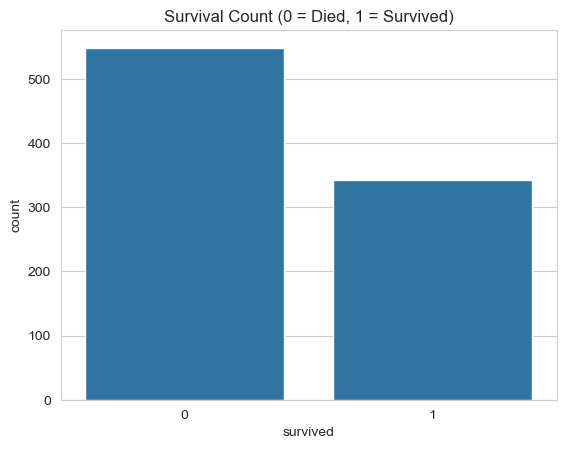

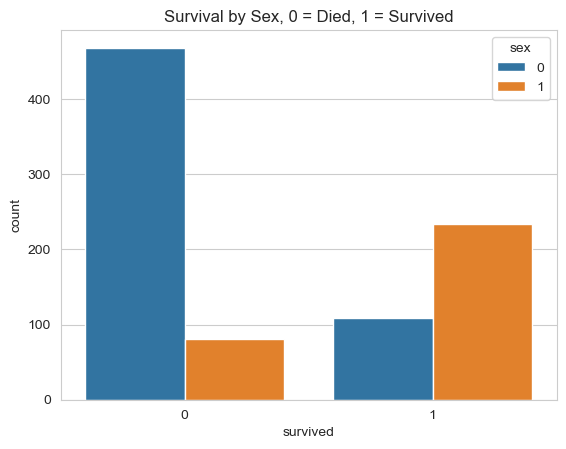

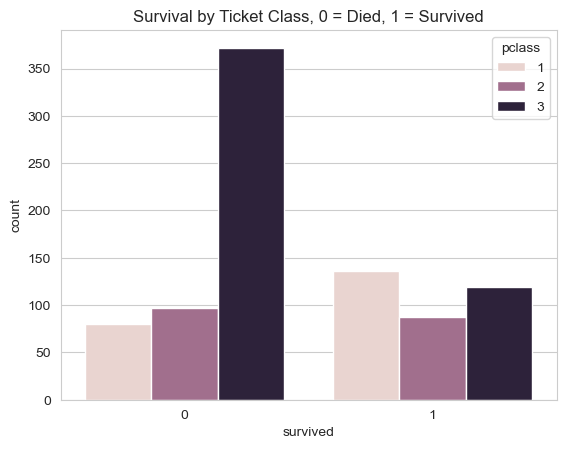

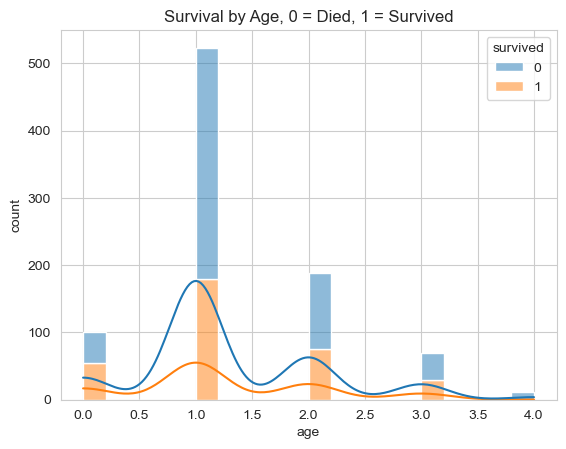

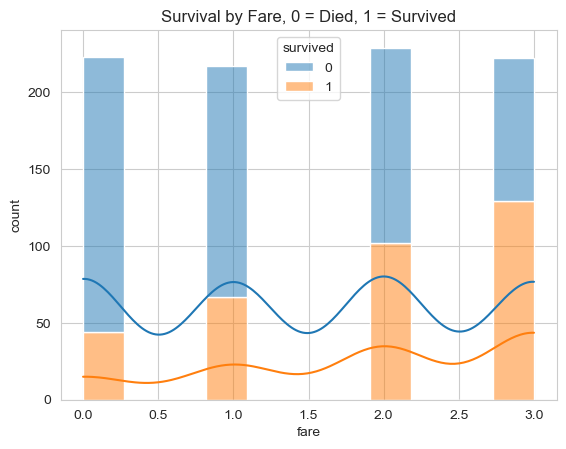

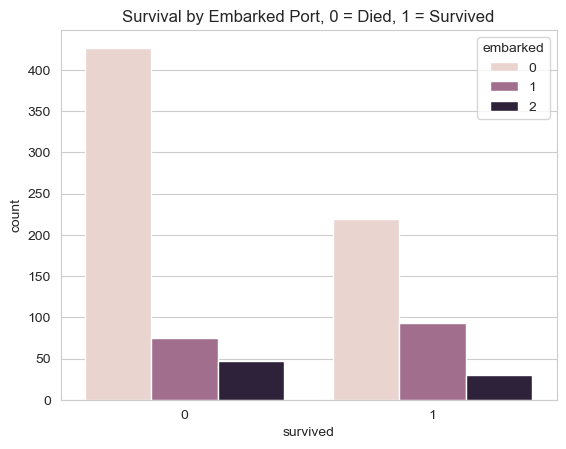

In [11]:
# visualize the data for some initial hypotheses and insights
sns.set_style("whitegrid")
sns.countplot(x="survived", data=train_df)
plt.title("Survival Count (0 = Died, 1 = Survived)")
plt.show()

# survival by sex
sns.countplot(x="survived", hue="sex", data=train_df)
plt.title("Survival by Sex, 0 = Died, 1 = Survived")
plt.show()

# survival by pclass
sns.countplot(x="survived", hue="pclass", data=train_df)
plt.title("Survival by Ticket Class, 0 = Died, 1 = Survived")
plt.show()

# survival by age
sns.histplot(train_df, x="age", hue="survived", multiple="stack", kde=True)
plt.title("Survival by Age, 0 = Died, 1 = Survived")
plt.xlabel("age")
plt.ylabel("count")
plt.show()

# survival by fare
sns.histplot(train_df, x="fare", hue="survived", multiple="stack", kde=True)
plt.title("Survival by Fare, 0 = Died, 1 = Survived")
plt.xlabel("fare")
plt.ylabel("count")
plt.show()

# survival by embarked
sns.countplot(x="survived", hue="embarked", data=train_df)
plt.title("Survival by Embarked Port, 0 = Died, 1 = Survived")
plt.show()

In [12]:
'''
# create fare_band feature
train_df['fare_band'] = 0 
train_df.loc[(train_df['fare'] > 10) & (train_df['fare'] <= 25), 'fare_band'] = 1
train_df.loc[(train_df['fare'] > 25) & (train_df['fare'] <= 50), 'fare_band'] = 2
train_df.loc[(train_df['fare'] > 50) & (train_df['fare'] <= 100), 'fare_band'] = 3
train_df.loc[train_df['fare'] > 100, 'fare_band'] = 4

# Analyze survival rate by fare band
print(train_df[['fare_band', 'survived']].groupby('fare_band').mean())
print(train_df.groupby('fare_band').size())
'''

"\n# create fare_band feature\ntrain_df['fare_band'] = 0 \ntrain_df.loc[(train_df['fare'] > 10) & (train_df['fare'] <= 25), 'fare_band'] = 1\ntrain_df.loc[(train_df['fare'] > 25) & (train_df['fare'] <= 50), 'fare_band'] = 2\ntrain_df.loc[(train_df['fare'] > 50) & (train_df['fare'] <= 100), 'fare_band'] = 3\ntrain_df.loc[train_df['fare'] > 100, 'fare_band'] = 4\n\n# Analyze survival rate by fare band\nprint(train_df[['fare_band', 'survived']].groupby('fare_band').mean())\nprint(train_df.groupby('fare_band').size())\n"

In [13]:
'''
Observations from EDA:
    - More people died than survived
    - Females had a higher survival rate
    - 1st class passengers survived more often
    - Younger passengers upto age 10 had a higher survival rate
    - Passengers who embarked from Cherbourg (C) had a higher survival rate compared to those from Southampton (S) and Queenstown (Q)
    - Passengers who paid higher fares had a higher survival rate
    - 
'''

'\nObservations from EDA:\n    - More people died than survived\n    - Females had a higher survival rate\n    - 1st class passengers survived more often\n    - Younger passengers upto age 10 had a higher survival rate\n    - Passengers who embarked from Cherbourg (C) had a higher survival rate compared to those from Southampton (S) and Queenstown (Q)\n    - Passengers who paid higher fares had a higher survival rate\n    - \n'